In [1]:
import numpy as np
from scipy.stats import norm
from collections import deque
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from scipy.stats import gaussian_kde
import pickle
import statsmodels.api as sm

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Enable memory growth for all GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("Enabled GPU acceleration")
else:
    print("No GPU available, training on CPU")

No GPU available, training on CPU


In [3]:
def plot(x,y,x_label,y_label,title, style):
    fig, ax = plt.subplots()
    ax.plot(x,y, style, label=y_label, )
    ax.legend()
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    plt.show()
def multiPlot(x,ys,x_label,y_label,title):
    fig, ax = plt.subplots()
    for k in range(len(ys)):
        ax.plot(x,ys[k][0],  ys[k][2], label= ys[k][1],)#marker =ys[k][2]
    ax.legend()
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    plt.show()


In [4]:
def european_option_price(S, K, T, r, sigma, option_type='call'):
    """
    Calculate the value of a European option using the Black-Scholes formula.

    Parameters:
        S (float): Current stock price.
        K (float): Strike price of the option.
        T (float): Time to expiration (in years).
        r (float): Risk-free interest rate (annualized).
        sigma (float): Volatility of the underlying stock (annualized).
        option_type (str): Type of option, either 'call' or 'put'.

    Returns:
        float: Value of the European option.
    """
    if T<0:
      print("error, T = " + str(T))
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T+ 10**-8))
    d2 = d1 - sigma * np.sqrt(T+ 10**-8)

    if option_type == 'call':
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Must be 'call' or 'put'.")

    return option_price
def delta_hedge_simulation(S0, K, T, D, r, sigma, N, mult, option_type='call', dt=0.01):
    """
    Simulate delta hedging over time for a European call option.

    Parameters:
        S0 (float): Initial stock price.
        K (float): Strike price of the option.
        T (float): Time to expiration (in years).
        r (float): Risk-free interest rate (annualized).
        sigma (float): Volatility of the underlying stock (annualized).
        option_type (str): Type of option, either 'call' or 'put'.
        num_steps (int): Number of time steps.
        dt (float): Time step size.

    Returns:
        tuple: Arrays of option value, underlying value, and total capital value over time.
    """
    num_steps = int(D*T*365)
    t = np.linspace(0, T, num_steps+1)
    underlying_values = np.zeros(num_steps+1)
    option_values = np.zeros(num_steps+1)
    stock_values = np.zeros(num_steps+1)
    rf_values = np.zeros(num_steps+1)
    n_stock = np.zeros(num_steps+1)
    #init
    option_values[0] = N*european_option_price(S0, K, T, r, sigma, option_type)
    rf_values[0] = -option_values[0]
    underlying_values[0] = S0
    for i in range(1, num_steps+1):

        t_i = t[i]
        S_i = underlying_values[i-1] * np.exp(r/D/365 + sigma * np.sqrt(1/D/365) * np.random.normal())
        underlying_values[i] = S_i
        delta = N*norm.cdf((np.log(S_i / K) + (r + 0.5 * sigma ** 2) * (T - t_i+ 10**-8)) / (sigma * np.sqrt(T - t_i+ 10**-8)))
        new_n = round(-delta)
        q = (new_n-n_stock[i-1])*S_i/S0
        a = 0.1/(0.5-D/2)**2
        ticksize = 0.05 + a*(i%D-D/2+0.5)**2
        c = mult*ticksize*(np.abs(q)+0.01*q**2)
        rf_values[i] = rf_values[i-1]-q*S0-c
        n_stock[i] = new_n
        stock_values[i] = n_stock[i]*S_i
        option_values[i] = N*european_option_price(S_i, K, T - t_i, r, sigma, option_type)
    return t, option_values, underlying_values, rf_values, n_stock, stock_values



In [5]:

class TradingEnvironment:
    def __init__(self, N, S0, K, T, r, sigma, D, kappa, mult, action_dim, option_type='call'):

        self.N = N  # Number of options
        self.S0 = S0
        self.K = K
        self.T = T  # Time horizon
        self.r = r  # Interest rate
        self.sigma = sigma # Volatility
        self.D = D
        self.num_steps = int(D*T*365)
        self.kappa = kappa
        self.mult = mult
        self.option_type = option_type
        self.t = np.linspace(0, T, num_steps+1)
        self.i = 0
        self.underlying_values = np.zeros(num_steps+1)
        self.option_values = np.zeros(num_steps+1)
        self.n_stock = np.zeros(num_steps+1)
        self.stock_values = np.zeros(num_steps+1)
        self.rf_values = np.zeros(num_steps+1)
        self.trading_cost = np.zeros(num_steps+1)
        self.wealth = np.zeros(num_steps+1)
        self.action_dim = action_dim
        na = self.action_dim//2
        self.beta = (self.N-na)/(na**2-na)
        self.lbd = (na-na**3)/(na**2-na)
        self.a = (0.1*self.N-na/2-self.beta*(na**2/4-na))/(na**3/8-na/2+self.lbd*(na**2/4-na/2))
        self.b = self.beta +self.lbd*self.a
        self.c = 1-self.b-self.a

    #init
        self.option_values[0] = N*european_option_price(S0, K, T, r, sigma, option_type)
        self.rf_values[0] = -self.option_values[0]
        self.underlying_values[0] = S0

    def reset(self):
        self.i = 0
        self.underlying_values[1:] = np.zeros(num_steps)
        self.option_values[1:] = np.zeros(num_steps)
        self.n_stock[1:] = np.zeros(num_steps)
        self.stock_values[1:] = np.zeros(num_steps)
        self.rf_values[1:] = np.zeros(num_steps)
        self.trading_cost[1:] = np.zeros(num_steps)
        self.wealth[1:] = np.zeros(num_steps)

        return(np.array([self.underlying_values[0], 
                         (self.num_steps - self.i)/self.num_steps*self.S0,
                         self.n_stock[0]*self.S0/self.N, ((self.i%self.D)/self.D*self.S0)]).reshape((1, -1)))
    def convert_action(self, action):

        action -= self.action_dim//2

        abs = np.abs(action)
        s = np.sign(action)
        return round((self.a*abs**3+self.b*abs**2+self.c*abs)*s)
    def cost(self, action):
        q = action*self.underlying_values[self.i]/self.S0
        a = 0.1/(0.5-self.D/2)**2
        ticksize = 0.05 + a*(self.i%self.D-self.D/2+0.5)**2
        return(self.mult*ticksize*(np.abs(q)+0.01*q**2))
    #def dividend(self):
        #return(self.dividend_yield/365*self.stock_values[self.i])
    def get_reward(self, dw):
        reward = dw-self.kappa/2*dw**2
        return reward
    def step(self, action):
        # Take an action in the environment and return the next state, reward, and done flag
        # Update self.state based on the action
        action = self.convert_action(action)
        self.i += 1
        S = self.underlying_values[self.i-1] * np.exp(self.r/365/self.D + self.sigma * np.sqrt(1/365/self.D) * np.random.normal())
        self.underlying_values[self.i] = S
        self.option_values[self.i] = self.N*european_option_price(S, self.K, self.T*(1- self.i/self.num_steps) , self.r, self.sigma, self.option_type)
        self.n_stock[self.i] = self.n_stock[self.i-1]+action
        self.stock_values[self.i] = self.n_stock[self.i]*S
        c = self.cost(action)
        self.rf_values[self.i] = self.rf_values[self.i-1]-action*S-c
        self.trading_cost[self.i] = self.trading_cost[self.i-1] + c
        self.wealth[self.i] = self.option_values[self.i] + self.stock_values[self.i] + self.rf_values[self.i]
        reward = self.get_reward(self.wealth[self.i]-self.wealth[self.i-1])
        done = self.i==self.num_steps
        next_state = np.array([S, (self.num_steps - self.i)/self.num_steps*self.S0, self.n_stock[self.i]*self.S0/self.N,(self.i%self.D/self.D*self.S0)]).reshape((1, -1))
        return next_state, reward, done
    def result(self):
        return(self.t*365,
        [[self.underlying_values,"underlying_values",'-'],[self.option_values,"option_values",'-'],
         [self.stock_values,"stock_values",'-'],[self.rf_values,"rf_values",'-'],
         [self.trading_cost,"trading_cost",'-'],[self.wealth,"total_wealth",'-'],[self.n_stock,"n_stock",'-']])




In [6]:
class RandomDeque(deque):
    def __init__(self, maxlen):
        super().__init__(maxlen=maxlen)

    def append(self, item):
        if len(self) == self.maxlen:
            self.rotate(-random.randint(0, len(self) - 1))  # Rotate the deque randomly
            self.pop()  # Remove the rightmost element
        super().append(item)

    def sample_batch(self, batch_size):
        return random.sample(self, min(len(self), batch_size))

In [7]:
def custom_loss(y_true, y_pred):
    # Compute softmax of predicted labels
    softmax_pred = tf.nn.softmax(y_true, axis=1)

    # Compute MSE between true labels and predicted labels
    mse = tf.reduce_mean(softmax_pred *tf.square(y_true - y_pred), axis=1)

    loss = tf.reduce_mean(mse, axis=0)

    return loss


class DeepQAgent:
    def __init__(self, state_dim, action_dim,
                 gamma, learning_rate, buffer_size, batch_size):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.replay_buffer = RandomDeque(maxlen=buffer_size)
        self.q_network = self.build_q_network()


    def build_q_network(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(32, input_dim=self.state_dim, activation='relu'),
            tf.keras.layers.Dense(80, activation='relu'),
            tf.keras.layers.Dense(self.action_dim, activation = 'softmax')
        ])
        model.compile(loss=custom_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model
    def choose_action(self, state, epsilon):
        if np.random.rand() <= epsilon:
            return np.random.choice(self.action_dim)
        else:
            q_values = self.q_network.predict(state, verbose=0)
            return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))

    def replay(self, v):
        if len(self.replay_buffer) < self.batch_size:
            #print(len(self.replay_buffer))
            return
        batch = self.replay_buffer.sample_batch(batch_size=self.batch_size)
        states = []
        targets = []
        temp_diffs = []
        for state, action, reward, next_state, done in batch:
            pred = self.q_network.predict(next_state, verbose=0)[0]
            y = reward + self.gamma * np.amax(pred)
            temp_diff = y - self.q_network.predict(state, verbose=0)[0][action]
            states.append(state[0])
            target = np.zeros(self.action_dim)
            target[np.argmax(action)] = y
            targets.append(target)
            temp_diffs.append(temp_diff)
        X_train = np.array(states)
        y_train = np.array(targets)
        #sample_weights = np.array(temp_diffs)  

        # Train the Q-network
        self.q_network.fit(X_train, y_train, epochs=1, verbose=v)
    
    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.__dict__, f)


    def load(cls, filename):
        with open(filename, 'rb') as f:
            agent_dict = pickle.load(f)
        agent = cls.__new__(cls)
        agent.__dict__.update(agent_dict)
        return agent

In [14]:
def estimate_corr(x):

    X = sm.add_constant(x[:-1])  # Lagged values of x
    y = x[1:]  # Current values of x

    # Fit AR(1) model using ordinary least squares
    model = sm.OLS(y, X)
    results = model.fit()
    # Estimated AR(1) coefficient
    return(results.params[1])
def train(agent,env,  num_episodes, num_steps, epsilon_decay_rate, replay_rate):
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        print("episode = " + str(episode))
        v=0
        while not done:
            
            progression = state[0][1]*num_steps/env.S0
            advancement = (episode*num_steps+num_steps- progression)/(num_episodes*num_steps)
            epsilon = max(0.01,np.exp(epsilon_decay_rate*advancement))
            if round(advancement*1000)%25==0:
                v = 1
                print("advancement = " + str(advancement))
                print(epsilon)
            action = agent.choose_action(state, epsilon)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if np.random.binomial(1,replay_rate)==1:
                agent.replay(v)
                v = 0
    return(agent)
def test(env, agent):
    state = env.reset()
    done = False
    while not done:
        action = agent.choose_action(state, 0)
        next_state, reward, done = env.step(action)
        state = next_state
    return(env.result())
def DH_performance(N_simulation, kappa):
    final_wealth = []
    for k in range(N_simulation):
        t, option_values, underlying_values, rf_values, n_stock, stock_values = delta_hedge_simulation(S0, K, T, D, r, sigma, N_option, mult)
        final_wealth.append(option_values[-1]+rf_values[-1]+ stock_values[-1])
    final_wealth = np.array(final_wealth)
    mean = np.mean(final_wealth)
    variance = np.var(final_wealth)
    kde = gaussian_kde(final_wealth)
    x = np.linspace(min(final_wealth), max(final_wealth), 1000)
    plt.plot(x, kde(x), label='Kernel Density Estimation')
    plt.xlabel('final_wealth')
    plt.ylabel('Density')
    plt.title('Kernel Density Estimation of the final wealth')
    plt.legend()
    plt.show()
    return(mean, variance, mean-kappa/2*variance)
def DQN_performance(N_simulation, env, agent):
    final_wealth = []
    coefs = []
    for k in range(N_simulation):
        t, result = test(env,agent)
        wealth = result[5][0]
        coefs.append(estimate_corr(np.diff(wealth)))
        final_wealth.append(wealth[-1])
    final_wealth = np.array(final_wealth)
    mean = np.mean(final_wealth)
    variance = np.var(final_wealth)
    kde = gaussian_kde(final_wealth)
    x = np.linspace(min(final_wealth), max(final_wealth), 100)
    plt.plot(x, kde(x), label='Kernel Density Estimation')
    plt.xlabel('final_wealth')
    plt.ylabel('Density')
    plt.title('Kernel Density Estimation of the final wealth')
    plt.legend()
    plt.show()
    print("DQN_mean = " + str(mean))
    print("DQN_var = " + str(variance))
    print("DQN_mean_var = " + str(mean-kappa/2*variance))
    coefs = np.array(coefs)
    plt.hist(coefs, bins=10)
    plt.title('Estimation of the AR(1) coef of wealth increments')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
    return(mean, variance, mean-kappa/2*variance)


# Without trading cost, ATM

In [9]:
# Parameters

# Option parameters
N_option = 1000 #number of options
option_type='call'
S0 = 100
K = 100
T = 10/365 #years
r = 0   # Risk-free interest rate (annual)
sigma = 0.01*365**0.5 # Volatility (annual)

# Constraints
D = 5 #max number of trading per day
mult = 0 # transaction cost multiplier
kappa = 0.1/(S0/100)**2  # risk aversion
state_dim = 4  # Dimensionality of the state space [underlying price, remaining time, n_share, moment of the day]
action_dim = 101  # Dimensionality of the action space

#learning parameters

epsilon_decay_rate = -3.5
gamma = 0.98
learning_rate=0.00001
batch_size=32
buffer_size = 2500
replay_rate = 0.1
num_steps = round(T*D*365)



In [10]:
# Initialize environment
env = TradingEnvironment(N_option, S0, K, T, r, sigma, D, kappa, mult, action_dim, option_type)

In [11]:
# Initialize agents
agent0 = DeepQAgent(state_dim, action_dim, gamma, learning_rate, buffer_size, batch_size)
agent = DeepQAgent(state_dim, action_dim, gamma, learning_rate, buffer_size, batch_size)


## Training

Training on 20 episodes

In [12]:
num_episodes  = 20
agent0 = train(agent0, env, num_episodes, num_steps, epsilon_decay_rate, replay_rate)

episode = 0
advancement = 0.0
1.0
advancement = 0.025
0.9162188716508776
1/1 [==============================] - 1s 566ms/step - loss: 7.0536e-05
episode = 1
advancement = 0.05
0.8394570207692074
1/1 [==============================] - 0s 4ms/step - loss: 7.3324e-05
advancement = 0.075
0.7691263643685705
1/1 [==============================] - 0s 4ms/step - loss: 7.5647e-05
episode = 2
advancement = 0.1
0.7046880897187134
1/1 [==============================] - 0s 5ms/step - loss: 0.0077
advancement = 0.125
0.645648526427892
1/1 [==============================] - 0s 5ms/step - loss: 0.0093
episode = 3
advancement = 0.15
0.5915553643668151
1/1 [==============================] - 0s 5ms/step - loss: 7.2397e-05
advancement = 0.175
0.5419941884591871
1/1 [==============================] - 0s 5ms/step - loss: 5.8940e-04
episode = 4
advancement = 0.2
0.49658530379140947
1/1 [==============================] - 0s 6ms/step - loss: 0.0057
advancement = 0.225
0.4549808267181735
1/1 [==================

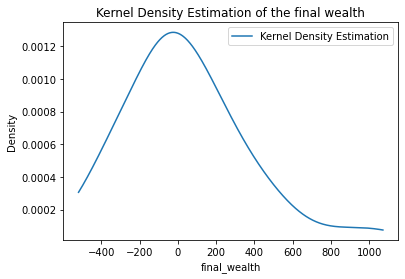

DH_mean = 40.365155333877965
DH_var = 102006.48170016974
DH_mean_var = -5059.95892967461


In [13]:
DH_mean, DH_var, DH_mean_var = DH_performance(50, kappa)
print("DH_mean = " + str(DH_mean))
print("DH_var = " + str(DH_var))
print("DH_mean_var = " + str(DH_mean_var))

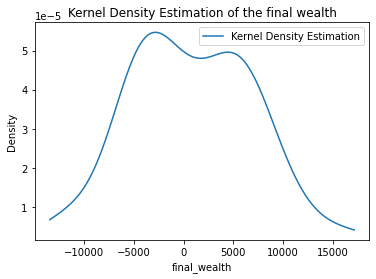

DQN_mean = 835.893470981369
DQN_var = 39375926.9191035
DQN_mean_var = -1967960.452484194


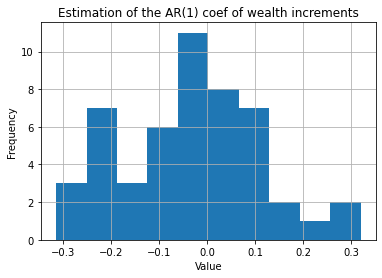

In [14]:
DQN_mean,DQN_var, DQN_mean_var = DQN_performance(50, env, agent0)


Training on 100 episodes

In [15]:
num_episodes  = 100
agent = train(agent, env, num_episodes, num_steps, epsilon_decay_rate, replay_rate)

episode = 0
advancement = 0.0
1.0
advancement = 0.0002
0.9993002449428433
advancement = 0.0004
0.9986009795428267
episode = 1
episode = 2
advancement = 0.0246
0.9175024763848472
advancement = 0.0248
0.9168604493870431
advancement = 0.025
0.9162188716508776
advancement = 0.0252
0.9155777428619776
advancement = 0.0254
0.9149370627061898
1/1 [==============================] - 0s 6ms/step - loss: 6.8618e-05
episode = 3
episode = 4
advancement = 0.0496
0.8406330836502107
advancement = 0.0498
0.8400448463987132
episode = 5
advancement = 0.05
0.8394570207692074
advancement = 0.0502
0.8388696064736585
advancement = 0.0504
0.8382826032242334
1/1 [==============================] - 0s 5ms/step - loss: 8.0494e-05
episode = 6
episode = 7
advancement = 0.0746
0.7702038953743938
advancement = 0.0748
0.7696649413035639
advancement = 0.075
0.7691263643685705
advancement = 0.0752
0.7685881643055111
advancement = 0.0754
0.7680503408506676
1/1 [==============================] - 0s 5ms/step - loss: 0.0053


1/1 [==============================] - 0s 6ms/step - loss: 1.0915e-04
episode = 66
episode = 67
advancement = 0.6746
0.09431641805408165
advancement = 0.6748
0.09425041966357543
1/1 [==============================] - 0s 4ms/step - loss: 5.5435e-05
advancement = 0.675
0.09418446745577665
advancement = 0.6752
0.0941185613983689
advancement = 0.6754
0.09405270145905806
1/1 [==============================] - 0s 6ms/step - loss: 4.6000e-05
episode = 68
episode = 69
advancement = 0.6996
0.08641448212766316
advancement = 0.6998
0.08635401315678275
episode = 70
advancement = 0.7
0.08629358649937054
advancement = 0.7002
0.08623320212581737
1/1 [==============================] - 0s 5ms/step - loss: 0.0012
advancement = 0.7004
0.08617286000653504
1/1 [==============================] - 0s 5ms/step - loss: 0.0028
episode = 71
episode = 72
advancement = 0.7246
0.07917457930930244
advancement = 0.7248
0.07911917649703253
advancement = 0.725
0.07906381245316065
advancement = 0.7252
0.07900848715055848

In [16]:
#test agent's behavior once
t,result = test(env,agent)

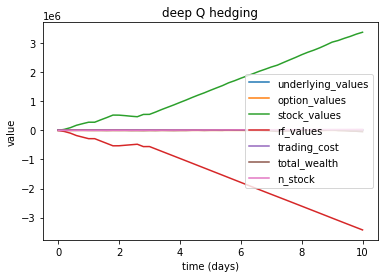

In [17]:
#plot agent behavior
multiPlot(t,result[:],"time (days)","value","deep Q hedging")

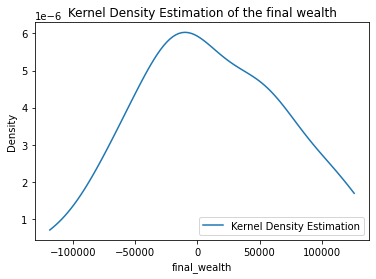

DQN_mean = 11790.164126916141
DQN_var = 3368770479.0516677
DQN_mean_var = -168426733.7884565


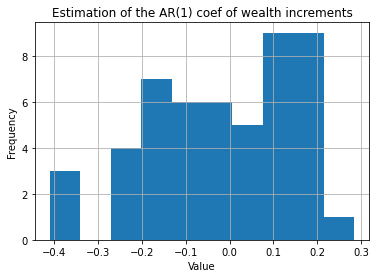

In [18]:
DQN_mean,DQN_var, DQN_mean_var = DQN_performance(50, env, agent)

# With trading cost, ITM

In [10]:
mult = 5
K = 100


In [16]:
env2 = TradingEnvironment(N_option, S0, K, T, r, sigma, D, kappa, mult, action_dim, option_type)

In [17]:

# Initialize agent
agent2 = DeepQAgent(state_dim, action_dim, gamma, learning_rate, buffer_size, batch_size)

## Training

In [18]:
num_episodes  = 100
agent2 = train(agent2, env2, num_episodes, num_steps, epsilon_decay_rate, replay_rate)

episode = 0
advancement = 0.0
1.0
advancement = 0.0002
0.9993002449428433
advancement = 0.0004
0.9986009795428267
episode = 1
episode = 2
advancement = 0.0246
0.9175024763848472
advancement = 0.0248
0.9168604493870431
advancement = 0.025
0.9162188716508776
advancement = 0.0252
0.9155777428619776
advancement = 0.0254
0.9149370627061898
1/1 [==============================] - 0s 11ms/step - loss: 0.0060
episode = 3
episode = 4
advancement = 0.0496
0.8406330836502107
advancement = 0.0498
0.8400448463987132
episode = 5
advancement = 0.05
0.8394570207692074
advancement = 0.0502
0.8388696064736585
advancement = 0.0504
0.8382826032242334
1/1 [==============================] - 0s 8ms/step - loss: 7.5179e-05
episode = 6
episode = 7
advancement = 0.0746
0.7702038953743938
1/1 [==============================] - 0s 7ms/step - loss: 0.0026
advancement = 0.0748
0.7696649413035639
advancement = 0.075
0.7691263643685705
advancement = 0.0752
0.7685881643055111
advancement = 0.0754
0.7680503408506676
1/1

episode = 62
advancement = 0.6246
0.11235407617135425
advancement = 0.6248
0.11227545583836121
advancement = 0.625
0.11219689052034373
advancement = 0.6252
0.11211838017880486
advancement = 0.6254
0.11203992477527455
1/1 [==============================] - 0s 12ms/step - loss: 5.0785e-05
episode = 63
episode = 64
advancement = 0.6496
0.10294092489509496
advancement = 0.6498
0.10286889146231122
1/1 [==============================] - 0s 14ms/step - loss: 4.5271e-04
episode = 65
advancement = 0.65
0.1027969084352864
advancement = 0.6502
0.10272497577874871
advancement = 0.6504
0.10265309345745127
1/1 [==============================] - 0s 6ms/step - loss: 5.7873e-05
episode = 66
episode = 67
advancement = 0.6746
0.09431641805408165
1/1 [==============================] - 0s 6ms/step - loss: 0.0027
advancement = 0.6748
0.09425041966357543
1/1 [==============================] - 0s 6ms/step - loss: 5.2413e-05
advancement = 0.675
0.09418446745577665
advancement = 0.6752
0.0941185613983689
1/1 [=

In [19]:
t,result = test(env2,agent2)

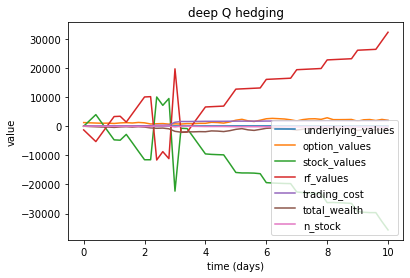

In [20]:
multiPlot(t,result[0:7],"time (days)","value","deep Q hedging")

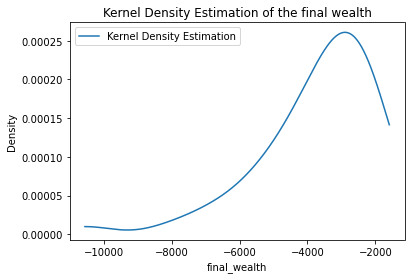

DH_mean = -3720.0093955654306
DH_var = 3044776.5031250324
DH_mean_var = -155958.83455181707


In [21]:
DH_mean, DH_var, DH_mean_var = DH_performance(50, kappa)
print("DH_mean = " + str(DH_mean))
print("DH_var = " + str(DH_var))
print("DH_mean_var = " + str(DH_mean_var))

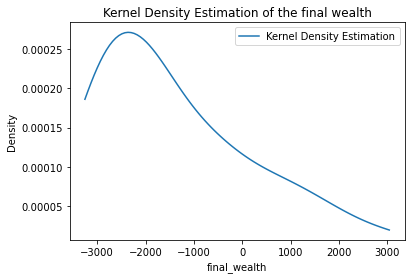

DQN_mean = -1384.5664271573407
DQN_var = 2457055.6517155785
DQN_mean_var = -124237.34901293628


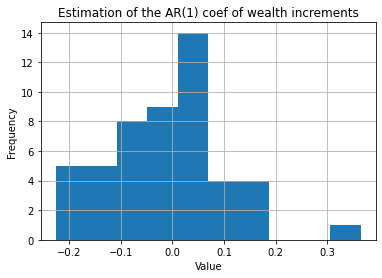

In [22]:

DQN_mean,DQN_var, DQN_mean_var = DQN_performance(50, env2, agent2)


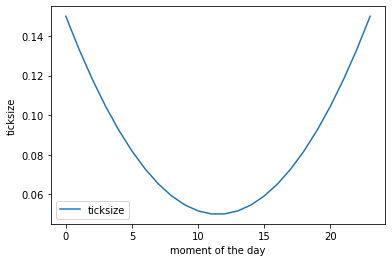

In [48]:
def ticksize_test(i, D):
    a = 0.1/(0.5-D/2)**2
    return( 0.05 + a*(i%D-D/2+0.5)**2)
D = 24
x = np.arange(0, D, 1)
y = []
for e in x:
    y.append(ticksize_test(e, D))
plot(x, y, "moment of the day", "ticksize", "", "-")
